# <font color="orange">Load modules</font> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection
from sklearn.pipeline import make_pipeline
import sklearn.ensemble
import numpy as np
import sklearn.linear_model as lm
import seaborn as sns
import sys
sys.path.append("/Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244")
from _CFG_Task_A import *
from _CLASS_ImageManager import *

In the following lines we load the labels .csv file.

In [2]:
# Now we load the label.csv file and store the gender labels in y variable, replacing -1 with 0
y = load_images_label_csv("gender")
y[y==-1] = 0

The following code is to remove the test_set in case this has been moved from celeba_test/img to celeba/img.

In [3]:
if count_n_images(sub_folder, extension) > 5000:
    move_images_fromfolder(sub_folder, sub_test_folder, extension)

# <font color="orange">Load and process images</font> 

We leverage on the **ImageManager** class object to load the whole set of images as well as crop them based on the body part we are interested in. The processing is based on a Haar Cascade Classifier. This is an effective object detection approach which was proposed by Paul Viola and Michael Jones back in 2001. This is basically a machine learning based approach where a cascade function is trained from a lot of images both positive and negative. Based on the training it is then used to detect the objects in the other images.
So how this works is they are huge individual .xml files with a lot of feature sets and each .xml corresponds to a very specific type of use case.

In [4]:
imgmgr = ImageManager()
imgmgr.load_images_from_folder(sub_folder, extension, verbose = True)
imgmgr.bodypart = "face"
imges = imgmgr.crop_part((36,36), squaring = False, x_offsets=(1/8,-1/8), y_offsets = (1/8,-1/8))

Starting to load images from /Users/macbookpro/UCL - MSc Integrated Machine Learning Systems/Y1/Applied Machine Learning I/Final Assignment/AMLS_20-21_SN17024244/Datasets/celeba/img/ with extension .jpg
2252/5000 images loaded
4528/5000 images loaded
5000/5000 images loaded


This is an example of an image in the celeba dataset after processing.

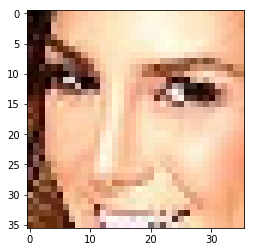

In [5]:
rgb = cv2.cvtColor(imges[0], cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

# <font color="orange">Solving exercise using various machine learning approches</font> 

Once our images have been processed, we can split our dataset into train and test sets.

In [6]:
X = imgmgr.images
X = X.reshape(X.shape[0], np.prod(X.shape[1:]))
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Initial Cross Validation

As a first step, we want to check for performance of linear classifiers (SVM and logistic regression) with SGD training. We also cross check the regulariser term by comparing L1 with L2 norms. The GridSearchCV function generates candidates from a grid of parameter values specified with the "param_grid" dictionary. 

In [7]:
param_grid = {"loss":[ "hinge", "log"], 
              "penalty":["l1", "l2"]}

clf = sklearn.model_selection.GridSearchCV(lm.SGDClassifier(), param_grid, cv=None)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']})

In [8]:
results_table = pd.DataFrame.from_dict(clf.cv_results_).set_index("rank_test_score")
results_table

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
2,7.049673,2.383721,0.008236,0.003168,hinge,l1,"{'loss': 'hinge', 'penalty': 'l1'}",0.861333,0.857333,0.869333,0.836000,0.838667,0.852533,0.013026
4,2.219465,0.247316,0.007650,0.001384,hinge,l2,"{'loss': 'hinge', 'penalty': 'l2'}",0.796000,0.852000,0.861333,0.806667,0.809333,0.825067,0.026350
1,9.503580,1.245200,0.007188,0.000400,log,l1,"{'loss': 'log', 'penalty': 'l1'}",0.873333,0.848000,0.868000,0.841333,0.834667,0.853067,0.015071
3,2.201787,0.603237,0.006840,0.000460,log,l2,"{'loss': 'log', 'penalty': 'l2'}",0.862667,0.834667,0.861333,0.785333,0.849333,0.838667,0.028510


Here below you will find 2 different approaches to the gender detection problem. Supervised learning techniques are used.

### 1. Support Vector Machine

From the table above, Support Vector Machine (loss="hinge") with L1 norm results to be the best classifier. We report here below the results.

A way to eliminate bias and normalise input features in our dataset is to apply a MinMaxScaler() function. This  rescales the data set such that all feature values are between 0 and 1. This function is very sensitive to outliers.

In [9]:
clf = make_pipeline(MinMaxScaler(), lm.SGDClassifier(loss='hinge', penalty='l1'))
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1894
           1       0.89      0.95      0.92      1856

    accuracy                           0.91      3750
   macro avg       0.92      0.91      0.91      3750
weighted avg       0.92      0.91      0.91      3750

TEST METRICS
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       606
           1       0.86      0.88      0.87       644

    accuracy                           0.86      1250
   macro avg       0.86      0.86      0.86      1250
weighted avg       0.86      0.86      0.86      1250



We present the confusion matrix once data has been trained using SVM.

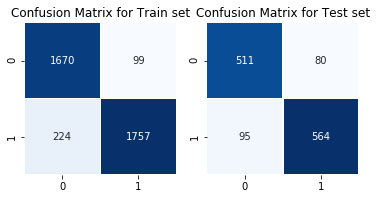

In [10]:
train_test_confusion_matrix(y_train, y_pred_train, y_test, y_pred_test)

### 2. Random Forest

Once a backtesting on the optimal number of trees is performed, then we can decide on the final n_estimator parameter. As you can see from the chart below, including ta least 20 trees will increase the accuracy significantly. As for the criterion parameter choice, I have noticed that the selection of impurity measure has little effect on the performance. However, Entropy returns lightly better results compared to Gini.

In [11]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators = 70, criterion="entropy", max_depth=5)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print("TRAIN METRICS")
print(sklearn.metrics.classification_report(y_train, y_pred_train))
print("TEST METRICS")
print(sklearn.metrics.classification_report(y_test, y_pred_test))

TRAIN METRICS
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1894
           1       0.85      0.87      0.86      1856

    accuracy                           0.86      3750
   macro avg       0.86      0.86      0.86      3750
weighted avg       0.86      0.86      0.86      3750

TEST METRICS
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       606
           1       0.76      0.82      0.79       644

    accuracy                           0.78      1250
   macro avg       0.78      0.77      0.77      1250
weighted avg       0.78      0.78      0.78      1250



No handles with labels found to put in legend.


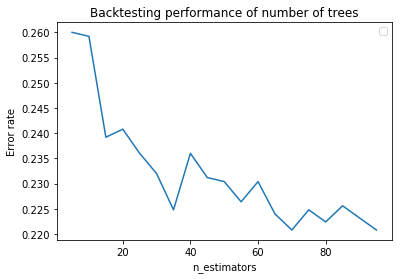

In [12]:
n_estimators=np.arange(5, 100, 5)

# Dictionary containing (<n_estimators> : <error rate>) pairs.
d = {}

for x in n_estimators:
    clf.set_params(n_estimators=x)
    clf.fit(X_train, y_train)
    error = 1 - clf.score(X_test, y_test)
    d[x] = error

plt.plot(d.keys(), d.values())
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.legend(loc="upper right")
plt.title('Backtesting performance of number of trees')
plt.show()

We present the confusion matrix once data has been trained using Random Forest.

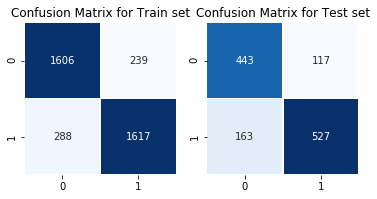

In [13]:
train_test_confusion_matrix(y_train, y_pred_train, y_test, y_pred_test)

Now we perform some hyper-parameter tuning to see if other Random Forest arguments would have led to a significantly higher performance. The below dictionary will test 4 different sizes of n_estimators and max_depth. We have initialised this process as we initially observed that allowing a flexible "max_depth" variable would lead to overfitting.

In [14]:
param_grid = {"n_estimators": [20, 40, 60, 80],
              "max_depth":    [5, 7, 10, 20]}

In [15]:
grid_clf = sklearn.model_selection.GridSearchCV(clf, param_grid, cv=5)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=5,
                                              n_estimators=95),
             param_grid={'max_depth': [5, 7, 10, 20],
                         'n_estimators': [20, 40, 60, 80]})

In [16]:
results_table = pd.DataFrame.from_dict(grid_clf.cv_results_).set_index("rank_test_score")
results_table

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
16,1.078319,0.036990,0.009929,0.002031,5,20,"{'max_depth': 5, 'n_estimators': 20}",0.777333,0.773333,0.800000,0.788000,0.790667,0.785867,0.009563
14,2.158781,0.020484,0.012289,0.001480,5,40,"{'max_depth': 5, 'n_estimators': 40}",0.776000,0.792000,0.824000,0.784000,0.780000,0.791200,0.017233
13,3.141887,0.067586,0.014002,0.001009,5,60,"{'max_depth': 5, 'n_estimators': 60}",0.788000,0.781333,0.820000,0.790667,0.777333,0.791467,0.015028
10,4.179834,0.040757,0.018757,0.001958,5,80,"{'max_depth': 5, 'n_estimators': 80}",0.792000,0.774667,0.813333,0.809333,0.797333,0.797333,0.013728
12,1.483752,0.022826,0.009006,0.000652,7,20,"{'max_depth': 7, 'n_estimators': 20}",0.800000,0.776000,0.808000,0.794667,0.793333,0.794400,0.010546
9,2.904299,0.091175,0.013959,0.003863,7,40,"{'max_depth': 7, 'n_estimators': 40}",0.798667,0.798667,0.828000,0.793333,0.804000,0.804533,0.012209
8,4.341179,0.032719,0.016359,0.001213,7,60,"{'max_depth': 7, 'n_estimators': 60}",0.809333,0.794667,0.829333,0.792000,0.802667,0.805600,0.013344
4,5.797386,0.083566,0.020139,0.001195,7,80,"{'max_depth': 7, 'n_estimators': 80}",0.813333,0.805333,0.841333,0.805333,0.802667,0.813600,0.014321
11,1.850921,0.059614,0.010008,0.000456,10,20,"{'max_depth': 10, 'n_estimators': 20}",0.806667,0.789333,0.806667,0.777333,0.802667,0.796533,0.011519
